## Problem 1 (a)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import math
import datetime 
from PIL import Image
from __future__ import print_function, division
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# TODO: Design dataset
class ImageDataset(Dataset):
    def __init__(self, input_dir, transform):
      self.dir=input_dir
      self.transform = transform
      
    def __len__ (self):
        
      length=0
      dir_list=os.listdir(self.dir)
      for i in range(len(dir_list)):
        if os.path.isdir(self.dir + "/" + dir_list[i]):
          length+=1
        
      return length
      
    def __getitem__(self, idx):
        
      input_dir=self.dir + "/" + str(idx) + "/" + str(idx) + "_input.jpg"
      mask_dir=self.dir + "/" + str(idx) + "/" + str(idx) + "_mask.png"
      input_data=self.transform(plt.imread(input_dir))
      mask_data=self.transform(plt.imread(mask_dir))
      data=[input_data,mask_data]
        
      return data

In [0]:
train_transformations = transforms.Compose([transforms.ToTensor()])
train_dir = 'DeepLearning/segmentation/train'
validation_dir = 'DeepLearning/segmentation/validation' 


train_dataset = ImageDataset(train_dir, train_transformations)
validation_dataset=ImageDataset(validation_dir, train_transformations)

In [0]:
train=DataLoader(dataset= train_dataset, batch_size=len(train_dataset), shuffle = False)
(image, label)=next(iter(train))
label_unique=np.unique(label)
n_max=len(label_unique)
n_max

8

In [0]:
################# Early stopping method #################
class EarlyStop(Dataset):
    """ The training process will be early stopped if there is no improvement after a given number of epochs.
    Args:
        patience (int):
            Number of epochs without improvement in the validation loss to wait before early stopping the training process.
            Default: 20
    """
    def __init__(self, patience=20):
      
        self.patience = patience
        self.epoch_wait = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        
    def __call__(self, validation_loss):
        
        loss = validation_loss

        if self.best_loss is None:
            self.best_loss = loss
        elif loss >= self.best_loss:
            self.epoch_wait += 1
            print('EarlyStopping counter:', self.epoch_wait, 'out of', self.patience)
            if self.epoch_wait >= self.patience:
                self.early_stop=True
        else:
            self.best_loss = loss
            #self.save_checkpoint(validation_loss, model)
            self.epoch_wait = 0 
    
#     def save_checkpoint(self, val_loss, model):
#         '''Saves model when validation loss decrease.'''
#         torch.save(model.state_dict(), 'checkpoint.pt')
#         self.val_loss_min = validation_loss

In [0]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )


# Upsampling
def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )


# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(3, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

    #TODO: Design your last layer & activations
    self.output=nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1, bias=True)


  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)

    #TODO: Design your last layer & activations
    output_out = torch.sigmoid(self.output(conv1m_out))
    

    return output_out

In [0]:
def one_hot_encoding(label):
    n_shape=list(label.shape)
    n_shape[1]=int(n_max)
    one_hot = torch.zeros(n_shape)
    for i in range(n_shape[0]):
      l_unique=np.unique(label[i])
      for j in range(len(l_unique)):
        I=np.where(label_unique == l_unique[j])
        one_hot[i,I,label[i,0]==l_unique[j]]=1
    one_hot = Variable(one_hot)
    
    return one_hot

In [0]:
def dice_loss(pred, true_label):
    smooth =1
    
    tp = (pred * true_label).sum(dim=3).sum(dim=2)
    p_pred = pred.sum(dim=3).sum(dim=2)
    p_label = true_label.sum(dim=3).sum(dim=2)

    dice = ((2 * tp + smooth) / (p_pred + p_label+ smooth))
    return (1-(dice.sum() / (dice.size(0)*dice.size(1))))

In [0]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000
# Patience for early stopping method
patience=20
# # Set tolerance for convergence
# tol=0.00001

In [0]:
device = torch.device("cuda:0")
model = unet(useBN=True).to(device)

In [0]:
def train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, num_epochs):
   
    # Load data with setted batch size
    train_batch = DataLoader(dataset= train_data, batch_size=train_batch_size, shuffle = True)
    val_batch = DataLoader(dataset= validation_data, batch_size=validation_batch_size, shuffle = False)

    # Optimization parameters
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    train_batch_num = int(len(train_batch))
    val_batch_num = int(len(val_batch))

    # Early stopping method
    early_stopping = EarlyStop(patience=patience)

    train_loss_record= []
    val_loss_record = []
    
    print("Start Training...")
    for epoch in range(num_epochs):
        ########################### Training #####################################
        print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
        # TODO: Design your own training section

        model.train()
        scheduler.step()
        train_loss = 0
        # Please design your own training section
        for i, (images, label) in enumerate(train_batch):
            images = Variable(images.float().cuda())
            output = model(images.to(device))
            label = Variable(one_hot_encoding(label).cuda())
            train_loss_temp = dice_loss(output, label)
            train_loss += train_loss_temp.item()

            ### backprop and use adam to optimize
            optimizer.zero_grad()
            train_loss_temp.backward()
            optimizer.step()
            
 
        # Record training loss
        train_loss_avg = train_loss/(train_batch_num)
        train_loss_record.append(train_loss_avg)
        print('Average Training Loss:', train_loss_avg)         

        ########################### Validation #####################################
        # Please design your own validation section
        
        model.eval() 
        val_loss=0
        for i, (images, label) in enumerate(val_batch):
            images = Variable(images.float().cuda())
            output = model(images.to(device))
            label = Variable(one_hot_encoding(label).cuda())
            val_loss_temp = dice_loss(output, label.to(device))
            val_loss += val_loss_temp.item()

        # Record validation loss
        val_loss_avg =  val_loss/(val_batch_num)
        val_loss_record.append(val_loss_avg)

        print('Average Validation Loss:', val_loss_avg) 

        early_stopping(val_loss_avg)

        if early_stopping.early_stop:
          print('Early stopping')
          break
        # if epoch>0:
        #   if (abs(val_loss_record[(epoch-1)]-val_loss_record[epoch])<tol):
        #     print('Algorithm converges')
        #     break


    return model, train_loss_record, val_loss_record

In [0]:
train_data, validation_data = train_dataset, validation_dataset
model, train_loss, valid_loss = train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, num_epochs)

Start Training...

EPOCH 1 of 1000



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Average Training Loss: 0.8285118798414867
Average Validation Loss: 0.8626088380813599

EPOCH 2 of 1000

Average Training Loss: 0.7684051831563313
Average Validation Loss: 0.7631775259971618

EPOCH 3 of 1000

Average Training Loss: 0.7508995493253072
Average Validation Loss: 0.7486898303031921

EPOCH 4 of 1000

Average Training Loss: 0.7485509872436523
Average Validation Loss: 0.7439069390296936

EPOCH 5 of 1000

Average Training Loss: 0.7448409199714661
Average Validation Loss: 0.740833842754364

EPOCH 6 of 1000

Average Training Loss: 0.7422230005264282
Average Validation Loss: 0.7396357774734497

EPOCH 7 of 1000

Average Training Loss: 0.7419649422168731
Average Validation Loss: 0.7409827470779419
EarlyStopping counter: 1 out of 20

EPOCH 8 of 1000

Average Training Loss: 0.7421065668265024
Average Validation Loss: 0.7408497929573059
EarlyStopping counter: 2 out of 20

EPOCH 9 of 1000

Average Training Loss: 0.7427040576934815
Average Validation Loss: 0.7385260820388794

EPOCH 10 of 

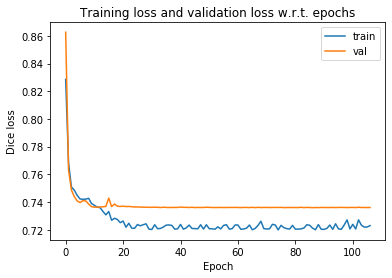

In [0]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(valid_loss)), valid_loss, label='val')
plt.title("Training loss and validation loss w.r.t. epochs")
plt.xlabel("Epoch")
plt.ylabel("Dice loss")
plt.legend()

In [0]:
test_dir = 'DeepLearning_fa19_HW6_Prob1/HW6_data/segmentation/test'
test_dataset = ImageDataset(test_dir, train_transformations)

Dice score of the test set is 0.2674558


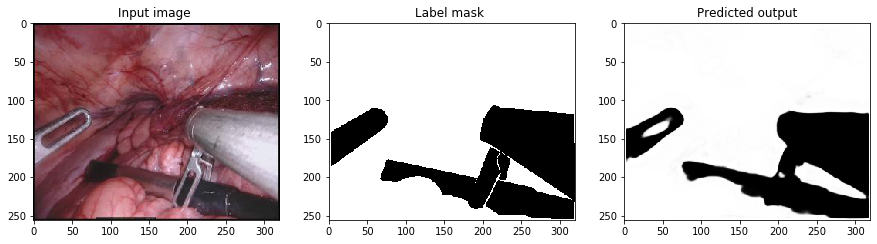

In [0]:
# Predict on the test set

model.eval()
with torch.no_grad():
    pred_dice_score=0
    test_batch = DataLoader(dataset= test_dataset, batch_size=10, shuffle = False)
    test_batch_num = len(test_batch)
    for i,(images, label) in enumerate(test_batch):
        images = Variable(images.float().cuda())
        output = model(images)
        label = Variable(one_hot_encoding(label).cuda())            
        dice_score = 1- dice_loss(output, label)
        pred_dice_score += dice_score
        
        if i==1:
          # Input image
          image1 = images[1].cpu().detach()
          image1 = image1.numpy().transpose(1,2,0)
          # Label mask
          label1 = label[1][0].cpu().detach()
          label1 = label1.view(256,320).numpy()
          # Predicted output
          output1 = output[1][0].cpu().detach()
          output1 = output1.view(256,320).numpy()
  
          fig, axs = plt.subplots(1, 3,figsize=(15,5))
          axs[0].imshow(image1)
          axs[0].set_title("Input image ")
          axs[1].imshow(label1,cmap='gray')
          axs[1].set_title("Label mask ")
          axs[2].imshow(output1,cmap='gray')
          axs[2].set_title("Predicted output")

    pred_dice_score = pred_dice_score/test_batch_num
    print('Dice score of the test set is',pred_dice_score.cpu().numpy())

## Problem 1(b)

In [0]:
train_transformation = transforms.Compose([transforms.ToPILImage(), transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
val_transformations = transforms.Compose([transforms.ToTensor()])
train_dir = 'DeepLearning/segmentation/train'
validation_dir = 'DeepLearning/segmentation/validation' 


train_dataset = ImageDataset(train_dir, train_transformations)
validation_dataset=ImageDataset(validation_dir, val_transformations)

In [0]:
train_data, validation_data = train_dataset, validation_dataset
model, train_loss, valid_loss = train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, num_epochs)

Start Training...

EPOCH 1 of 1000



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Average Training Loss: 0.8264366229375203
Average Validation Loss: 0.84154714345932

EPOCH 2 of 1000

Average Training Loss: 0.7612085243066152
Average Validation Loss: 0.7647395491600036

EPOCH 3 of 1000

Average Training Loss: 0.7493378599484761
Average Validation Loss: 0.7548805594444274

EPOCH 4 of 1000

Average Training Loss: 0.746526688337326
Average Validation Loss: 0.7430906057357788

EPOCH 5 of 1000

Average Training Loss: 0.744251823425293
Average Validation Loss: 0.7409268617630005

EPOCH 6 of 1000

Average Training Loss: 0.7446633080641428
Average Validation Loss: 0.7404245495796203

EPOCH 7 of 1000

Average Training Loss: 0.7420072615146637
Average Validation Loss: 0.747524869441986
EarlyStopping counter: 1 out of 20

EPOCH 8 of 1000

Average Training Loss: 0.7434756060441335
Average Validation Loss: 0.7408369898796081
EarlyStopping counter: 2 out of 20

EPOCH 9 of 1000

Average Training Loss: 0.7426855127016704
Average Validation Loss: 0.7566587328910828
EarlyStopping cou

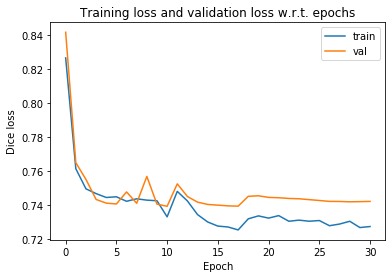

In [0]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(valid_loss)), valid_loss, label='val')
plt.title("Training loss and validation loss w.r.t. epochs")
plt.xlabel("Epoch")
plt.ylabel("Dice loss")
plt.legend()

In [0]:
# Predict on the test set
def test_model(model, test_data,test_batch_size):
    model.eval()
    with torch.no_grad():
        pred_dice_score=0
        test_batch = DataLoader(dataset= test_data, batch_size=test_batch_size, shuffle = False)
        test_batch_num = len(test_batch)
        for i,(images, label) in enumerate(test_batch):
            images = Variable(images.float().cuda())
            output = model(images)
            label = Variable(one_hot_encoding(label).cuda())            
            dice_score = 1- dice_loss(output, label)
            pred_dice_score += dice_score
            
            if i==1:
              # Input image
              image1 = images[1].cpu().detach()
              image1 = image1.numpy().transpose(1,2,0)
              # Label mask
              label1 = label[1][0].cpu().detach()
              label1 = label1.view(256,320).numpy()
              # Predicted output
              output1 = output[1][0].cpu().detach()
              output1 = output1.view(256,320).numpy()
      
              fig, axs = plt.subplots(1, 3,figsize=(15,5))
              axs[0].imshow(image1)
              axs[0].set_title("Input image ")
              axs[1].imshow(label1,cmap='gray')
              axs[1].set_title("Label mask ")
              axs[2].imshow(output1,cmap='gray')
              axs[2].set_title("Predicted output")

        pred_dice_score = pred_dice_score/test_batch_num
        print('Dice score of the test set is',pred_dice_score.cpu().numpy())
    
    return(pred_dice_score)

In [0]:
test_dir = 'DeepLearning/segmentation/test'
test_dataset = ImageDataset(test_dir, val_transformations)

Dice score of the test set is 0.26023048


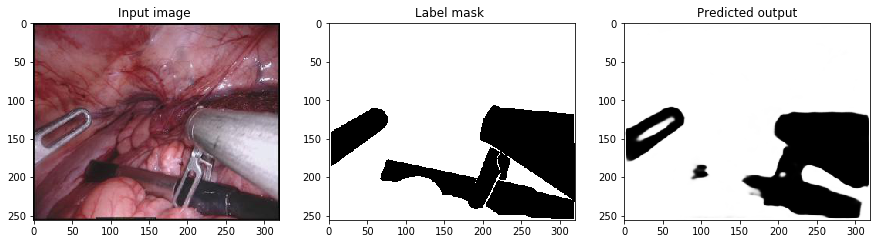

In [0]:
test_data= test_dataset
test_batch_size=10
pred_dice_score = test_model(model, test_data, test_batch_size)

## Problem 1(c)

In [0]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000
# Patience for early stopping method
patience=20
# Set tolerance for convergence
tol=0.0000001

device = torch.device("cuda:0")

In [0]:
def train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, num_epochs):
   
    # Load data with setted batch size
    train_batch = DataLoader(dataset= train_data, batch_size=train_batch_size, shuffle = True)
    val_batch = DataLoader(dataset= validation_data, batch_size=validation_batch_size, shuffle = False)

    # Optimization parameters
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    train_batch_num = int(len(train_batch))
    val_batch_num = int(len(val_batch))

    # Early stopping method
    early_stopping = EarlyStop(patience=patience)

    train_loss_record= []
    val_loss_record = []
    
    print("Start Training...")
    for epoch in range(num_epochs):
        ########################### Training #####################################
        print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
        # TODO: Design your own training section

        model.train()
        # Set the learning rate to be a constant
        # if epoch>0:
        #   scheduler.step()
        train_loss = 0
        # Please design your own training section
        for i, (images, label) in enumerate(train_batch):
            images = Variable(images.float().cuda())
            output = model(images.to(device))
            label = Variable(one_hot_encoding(label).cuda())
            train_loss_temp = dice_loss(output, label)
            train_loss += train_loss_temp.item()

            ### backprop and use adam to optimize
            optimizer.zero_grad()
            train_loss_temp.backward()
            optimizer.step()
            
 
        # Record training loss
        train_loss_avg = train_loss/(train_batch_num)
        train_loss_record.append(train_loss_avg)
        print('Average Training Loss:', train_loss_avg)         

        ########################### Validation #####################################
        # Please design your own validation section
        
        model.eval() 
        val_loss=0
        for i, (images, label) in enumerate(val_batch):
            images = Variable(images.float().cuda())
            output = model(images.to(device))
            label = Variable(one_hot_encoding(label).cuda())
            val_loss_temp = dice_loss(output, label.to(device))
            val_loss += val_loss_temp.item()

        # Record validation loss
        val_loss_avg =  val_loss/(val_batch_num)
        val_loss_record.append(val_loss_avg)

        print('Average Validation Loss:', val_loss_avg) 

        early_stopping(val_loss_avg)

        if early_stopping.early_stop:
          print('Early stopping')
          break
        if epoch>0:
          if (abs(val_loss_record[(epoch-1)]-val_loss_record[epoch])<tol):
            print('Algorithm converges')
            break


    return model, train_loss_record, val_loss_record

In [0]:
train_transformations = transforms.Compose([transforms.ToPILImage(), transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
val_transformations = transforms.Compose([transforms.ToTensor()])
train_dir = 'DeepLearning/segmentation/train'
validation_dir = 'DeepLearning/segmentation/validation' 


train_dataset = ImageDataset(train_dir, train_transformations)
validation_dataset=ImageDataset(validation_dir, val_transformations)

In [0]:
train_data, validation_data = train_dataset, validation_dataset
model, train_loss, valid_loss = train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, num_epochs)

Start Training...

EPOCH 1 of 1000

Average Training Loss: 0.8648862322171529
Average Validation Loss: 0.8299598336219788

EPOCH 2 of 1000

Average Training Loss: 0.8449336727460225
Average Validation Loss: 0.8200020074844361

EPOCH 3 of 1000

Average Training Loss: 0.8413546939690908
Average Validation Loss: 0.7750231146812439

EPOCH 4 of 1000

Average Training Loss: 0.8425577759742737
Average Validation Loss: 0.7892551064491272
EarlyStopping counter: 1 out of 20

EPOCH 5 of 1000

Average Training Loss: 0.8359406570593516
Average Validation Loss: 0.7974802851676941
EarlyStopping counter: 2 out of 20

EPOCH 6 of 1000

Average Training Loss: 0.8394986828168233
Average Validation Loss: 0.7664300203323364

EPOCH 7 of 1000

Average Training Loss: 0.834935086965561
Average Validation Loss: 0.7760957837104797
EarlyStopping counter: 1 out of 20

EPOCH 8 of 1000

Average Training Loss: 0.8315623005231222
Average Validation Loss: 0.7687920570373535
EarlyStopping counter: 2 out of 20

EPOCH 9 of

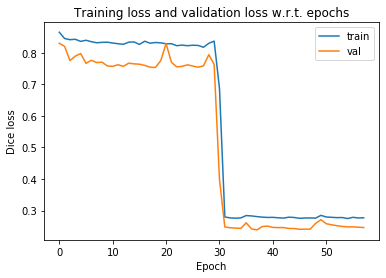

In [0]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(valid_loss)), valid_loss, label='val')
plt.title("Training loss and validation loss w.r.t. epochs")
plt.xlabel("Epoch")
plt.ylabel("Dice loss")
plt.legend()

In [0]:
test_dir = 'DeepLearning/segmentation/test'
test_dataset = ImageDataset(test_dir, val_transformations)

Dice score of the test set is 0.7200337


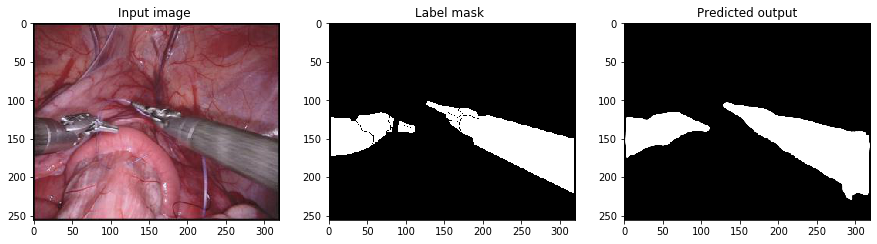

In [0]:
# Predict on the test set

model.eval()
with torch.no_grad():
    pred_dice_score=0
    test_batch = DataLoader(dataset= test_dataset, batch_size=10, shuffle = False)
    test_batch_num = len(test_batch)
    for i,(images, label) in enumerate(test_batch):
        images = Variable(images.float().cuda())
        output = model(images)
        label = Variable(one_hot_encoding(label).cuda())            
        dice_score = 1- dice_loss(output, label)
        pred_dice_score += dice_score
        
        if i==4:
          # Input image
          image1 = images[0].cpu().detach()
          image1 = image1.numpy().transpose(1,2,0)
          # Label mask
          label1 = label[0][3].cpu().detach()
          label1 = label1.view(256,320).numpy()
          # Predicted output
          output1 = output[0][3].cpu().detach()
          output1 = output1.view(256,320).numpy()
  
          fig, axs = plt.subplots(1, 3,figsize=(15,5))
          axs[0].imshow(image1)
          axs[0].set_title("Input image ")
          axs[1].imshow(label1,cmap='gray')
          axs[1].set_title("Label mask ")
          axs[2].imshow(output1,cmap='gray')
          axs[2].set_title("Predicted output")

    pred_dice_score = pred_dice_score/test_batch_num
    print('Dice score of the test set is',pred_dice_score.cpu().numpy())

## Problem 1(d)

In [0]:
# TODO: Design your own dataset
class ImageDataset(Dataset):
    def __init__(self, input_dir, transform, sets):
      self.dir=input_dir
      self.transform = transform
      self.sets=sets
      
    def __len__ (self):
        
      length=0
      dir_list=os.listdir(self.dir)
      for i in range(len(dir_list)):
        if os.path.isdir(self.dir + "/" + dir_list[i]):
          length+=1
        
      return length
      
    def __getitem__(self, idx):

      if self.sets=='train':
            image_dir = self.dir + '/' + str(idx) + '/' + str(idx) + '_gray.jpg'
            label_dir = self.dir + '/' + str(idx) + '/' + str(idx) + '_input.jpg'
            image = io.imread(image_dir)
            image = np.expand_dims(image, axis=2)
            label = io.imread(label_dir)
            label = self.transform(label)
      elif self.sets=='validation':           
            image_dir = self.dir + '/' + str(idx+1) + '/' + str(idx+1) + '_gray.jpg'
            label_dir = self.dir + '/' + str(idx+1) + '/' + str(idx+1) + '_input.jpg'
            image = io.imread(image_dir)
            image = np.expand_dims(image, axis=2)
            label = io.imread(label_dir)
            label = self.transform(label)
      elif self.sets=='test':
            image_dir = self.dir + '/' + str(idx) + '/' + str(idx) + '_gray.jpg'
            label_dir = self.dir + '/' + str(idx) + '/' + str(idx) + '_input.jpg'
            image = io.imread(image_dir)
            image = np.expand_dims(image, axis=2)
            label = io.imread(label_dir)
            label = self.transform(label)
      
      image=self.transform(image)
      data=[image,label]
        
      return data

In [0]:
train_transformations = transforms.Compose([transforms.ToTensor()])
train_dir = 'DeepLearning/colorization/train_cor'
validation_dir = 'DeepLearning/colorization/validation_cor' 


train_dataset = ImageDataset(train_dir, train_transformations,sets='train')
validation_dataset=ImageDataset(validation_dir, train_transformations,sets='validation')

In [0]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )


# Upsampling
def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )


# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(1, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

    #TODO: Design your last layer & activations
    self.output=nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1, bias=True)


  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)

    #TODO: Design your last layer & activations
    output_out = torch.sigmoid(self.output(conv1m_out))
    

    return output_out

In [0]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 20
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000
# Patience for early stopping method
patience=20
# Set tolerance for convergence
tol=0.00001

device = torch.device("cuda:0")

In [0]:
model = unet(useBN=True).to(device)

In [0]:
def train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, tol,num_epochs):
   
    # Load data with setted batch size
    train_batch = DataLoader(dataset= train_data, batch_size=train_batch_size, shuffle = True)
    val_batch = DataLoader(dataset= validation_data, batch_size=validation_batch_size, shuffle = False)

    # Optimization parameters
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # Loss function: MSE loss
    loss=torch.nn.MSELoss(reduction="mean")
    
    train_batch_num = int(len(train_batch))
    val_batch_num = int(len(val_batch))

    # Early stopping method
    early_stopping = EarlyStop(patience=patience)

    train_loss_record= []
    val_loss_record = []
    
    print("Start Training...")
    for epoch in range(num_epochs):
        ########################### Training #####################################
        print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
        # TODO: Design your own training section

        model.train()
        # Set the learning rate to be a constant
        #scheduler.step()
        train_loss = 0
        # Please design your own training section
        for i, (images, label) in enumerate(train_batch):
            output = model(images.to(device))
            train_loss_temp = loss(output, label.to(device))
            train_loss += train_loss_temp.item()

            ### backprop and use adam to optimize
            optimizer.zero_grad()
            train_loss_temp.backward()
            optimizer.step()
            
 
        # Record training loss
        train_loss_avg = train_loss/(train_batch_num)
        train_loss_record.append(train_loss_avg)
        print('Average Training Loss:', train_loss_avg)         

        ########################### Validation #####################################
        # Please design your own validation section
        
        model.eval() 
        val_loss=0
        for i, (images, label) in enumerate(val_batch):
            output = model(images.to(device))
            val_loss_temp = loss(output, label.to(device))
            val_loss += val_loss_temp.item()

        # Record validation loss
        val_loss_avg =  val_loss/(val_batch_num)
        val_loss_record.append(val_loss_avg)

        print('Average Validation Loss:', val_loss_avg) 

        early_stopping(val_loss_avg)

        if early_stopping.early_stop:
          print('Early stopping')
          break
        if epoch>0:
          if (abs(val_loss_record[(epoch-1)]-val_loss_record[epoch])<tol):
            print('Algorithm converges')
            break



    return model, train_loss_record, val_loss_record

In [0]:
train_data, validation_data = train_dataset, validation_dataset
model, train_loss, valid_loss = train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience,tol,num_epochs)

Start Training...

EPOCH 1 of 1000

Average Training Loss: 0.0043366745099774565
Average Validation Loss: 0.0022479092236608266

EPOCH 2 of 1000

Average Training Loss: 0.0012697278798441403
Average Validation Loss: 0.0018460360588505864

EPOCH 3 of 1000

Average Training Loss: 0.0010206504201050847
Average Validation Loss: 0.002208066778257489
EarlyStopping counter: 1 out of 20

EPOCH 4 of 1000

Average Training Loss: 0.0009516733400232625
Average Validation Loss: 0.001600740780122578

EPOCH 5 of 1000

Average Training Loss: 0.0009198085710522719
Average Validation Loss: 0.0016966432565823197
EarlyStopping counter: 1 out of 20

EPOCH 6 of 1000

Average Training Loss: 0.0007901411641796585
Average Validation Loss: 0.001558863092213869

EPOCH 7 of 1000

Average Training Loss: 0.0007637873277417384
Average Validation Loss: 0.0012896722415462135

EPOCH 8 of 1000

Average Training Loss: 0.0007223962820717134
Average Validation Loss: 0.0020681930240243674
EarlyStopping counter: 1 out of 20


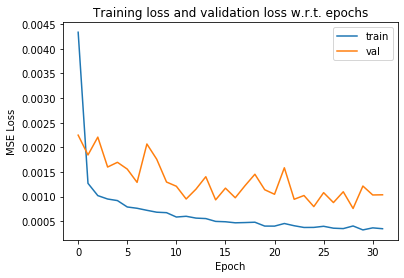

In [0]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(valid_loss)), valid_loss, label='val')
plt.title("Training loss and validation loss w.r.t. epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

MSE loss of the validation set is 0.0010373276891186833


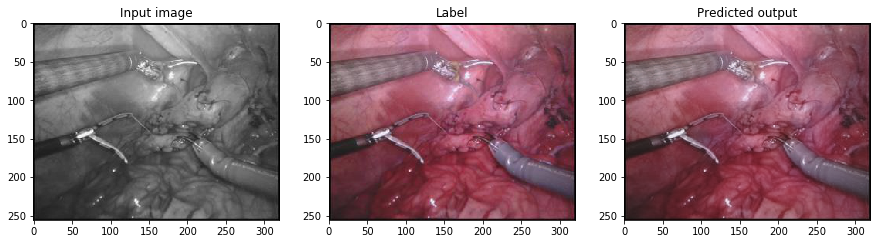

In [0]:
# Predict on the test set

model.eval()
with torch.no_grad():
    val_batch = DataLoader(dataset= validation_data, batch_size=validation_batch_size, shuffle = False)
    val_batch_num = int(len(val_batch))
    loss=torch.nn.MSELoss(reduction="mean")
    pred_loss=0
    for i,(images, label) in enumerate(val_batch):
        images = Variable(images.float().cuda())
        output = model(images)   
        loss_temp = loss(output, label.to(device))
        pred_loss += loss_temp.item()
        
        if i==0:
          images1=images[0].cpu().detach().numpy()
          #images1=np.transpose(images1,(1,2,0))
          images1=images1.squeeze()
          label1=label[0].cpu().detach().numpy()
          label1=np.transpose(label1,(1,2,0))
          output1=output[0].cpu().detach().numpy()
          output1=np.transpose(output1,(1,2,0))
          fig, axs = plt.subplots(1, 3,figsize=(15,5))
          axs[0].imshow(images1,cmap='gray')
          axs[0].set_title("Input image")
          axs[1].imshow(label1)
          axs[1].set_title("Label")
          axs[2].imshow(output1)
          axs[2].set_title("Predicted output")

    pred_loss = pred_loss/val_batch_num
    print('MSE loss of the validation set is',pred_loss)

In [0]:
model_save = 'colorization.pt'
path = "/content/drive/My Drive/"+ model_save 
torch.save(model.state_dict(), path)

## Problem 1(e)

In [0]:
# TODO: Design your own dataset
class ImageDataset(Dataset):
    def __init__(self, input_dir, transform):
      self.dir=input_dir
      self.transform = transform
      
    def __len__ (self):
        
      length=0
      dir_list=os.listdir(self.dir)
      for i in range(len(dir_list)):
        if os.path.isdir(self.dir + "/" + dir_list[i]):
          length+=1
        
      return length
      
    def __getitem__(self, idx):
        
      input_dir=self.dir + "/" + str(idx) + "/" + str(idx) + "_input.jpg"
      mask_dir=self.dir + "/" + str(idx) + "/" + str(idx) + "_mask.png"
      input_data=self.transform(plt.imread(input_dir))
      mask_data=self.transform(plt.imread(mask_dir))
      data=[input_data,mask_data]
        
      return data

In [0]:
train_transformations = transforms.Compose([transforms.ToPILImage(), transforms.RandomVerticalFlip(), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
val_transformations = transforms.Compose([transforms.ToTensor()])
train_dir = 'DeepLearning/segmentation/train'
validation_dir = 'DeepLearning/segmentation/validation' 


train_dataset = ImageDataset(train_dir, train_transformations)
validation_dataset=ImageDataset(validation_dir, val_transformations)

In [0]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )


# Upsampling
def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )


# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(3, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

    #TODO: Design your last layer & activations
    self.output=nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1, bias=True)


  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_)

    #TODO: Design your last layer & activations
    output_out = torch.sigmoid(self.output(conv1m_out))
    

    return output_out

In [0]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000
# Patience for early stopping method
patience=20
# Set tolerance for convergence
tol=0.0000001

device = torch.device("cuda:0")

In [0]:
model_save = 'colorization.pt'
path = "/content/drive/My Drive/"+ model_save 

In [0]:
model = unet(useBN=True).to(device)
model_dict=model.state_dict()
# Load pretrained model
pretrained_model=torch.load(path)
pretrained_model_dict=list(pretrained_model.items())
# Use the pretrained model to initialize all weights but the first and last layer
for i, (layer, weights) in enumerate(model_dict.items()):
  if i==0:
    (layer_pre, weights_pre)=pretrained_model_dict[i]
    model_dict[layer]=torch.cat([weights_pre]*3,dim=1)
  elif i<(len(model_dict)-2):
    (layer_pre, weights_pre)=pretrained_model_dict[i]
    model_dict[layer]=weights_pre
model.load_state_dict(model_dict)
model.train(True)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

In [0]:
def train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, num_epochs):
   
    # Load data with setted batch size
    train_batch = DataLoader(dataset= train_data, batch_size=train_batch_size, shuffle = True)
    val_batch = DataLoader(dataset= validation_data, batch_size=validation_batch_size, shuffle = False)

    # Optimization parameters
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    train_batch_num = int(len(train_batch))
    val_batch_num = int(len(val_batch))

    # Early stopping method
    early_stopping = EarlyStop(patience=patience)

    train_loss_record= []
    val_loss_record = []
    
    print("Start Training...")
    for epoch in range(num_epochs):
        ########################### Training #####################################
        print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
        # TODO: Design your own training section

        model.train()
        # Set the learning rate to be a constant
        # if epoch>0:
        #   scheduler.step()
        train_loss = 0
        # Please design your own training section
        for i, (images, label) in enumerate(train_batch):
            images = Variable(images.float().cuda())
            output = model(images.to(device))
            label = Variable(one_hot_encoding(label).cuda())
            train_loss_temp = dice_loss(output, label)
            train_loss += train_loss_temp.item()

            ### backprop and use adam to optimize
            optimizer.zero_grad()
            train_loss_temp.backward()
            optimizer.step()
            
 
        # Record training loss
        train_loss_avg = train_loss/(train_batch_num)
        train_loss_record.append(train_loss_avg)
        print('Average Training Loss:', train_loss_avg)         

        ########################### Validation #####################################
        # Please design your own validation section
        
        model.eval() 
        val_loss=0
        for i, (images, label) in enumerate(val_batch):
            images = Variable(images.float().cuda())
            output = model(images.to(device))
            label = Variable(one_hot_encoding(label).cuda())
            val_loss_temp = dice_loss(output, label.to(device))
            val_loss += val_loss_temp.item()

        # Record validation loss
        val_loss_avg =  val_loss/(val_batch_num)
        val_loss_record.append(val_loss_avg)

        print('Average Validation Loss:', val_loss_avg) 

        early_stopping(val_loss_avg)

        if early_stopping.early_stop:
          print('Early stopping')
          break
        if epoch>0:
          if (abs(val_loss_record[(epoch-1)]-val_loss_record[epoch])<tol):
            print('Algorithm converges')
            break


    return model, train_loss_record, val_loss_record

In [0]:
train_data, validation_data = train_dataset, validation_dataset
model, train_loss, valid_loss = train_model(model, train_data, validation_data,train_batch_size, validation_batch_size,patience, num_epochs)

Start Training...

EPOCH 1 of 1000

Average Training Loss: 0.8688425521055857
Average Validation Loss: 0.8452975630760193

EPOCH 2 of 1000

Average Training Loss: 0.8487434923648834
Average Validation Loss: 0.8263978600502014

EPOCH 3 of 1000

Average Training Loss: 0.8443973223368327
Average Validation Loss: 0.8059713959693908

EPOCH 4 of 1000

Average Training Loss: 0.8367519160111745
Average Validation Loss: 0.7814563274383545

EPOCH 5 of 1000

Average Training Loss: 0.8379533052444458
Average Validation Loss: 0.7696149110794067

EPOCH 6 of 1000

Average Training Loss: 0.8345959345499675
Average Validation Loss: 0.7647311806678772

EPOCH 7 of 1000

Average Training Loss: 0.8340214431285858
Average Validation Loss: 0.7732221126556397
EarlyStopping counter: 1 out of 20

EPOCH 8 of 1000

Average Training Loss: 0.8375183343887329
Average Validation Loss: 0.7777838349342346
EarlyStopping counter: 2 out of 20

EPOCH 9 of 1000

Average Training Loss: 0.8330661217371623
Average Validation L

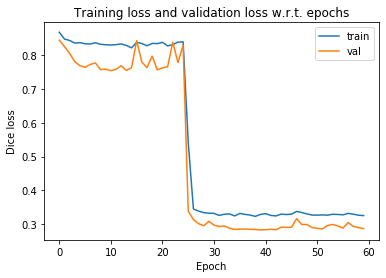

In [0]:
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(valid_loss)), valid_loss, label='val')
plt.title("Training loss and validation loss w.r.t. epochs")
plt.xlabel("Epoch")
plt.ylabel("Dice loss")
plt.legend()

In [0]:
test_dir = 'DeepLearning/segmentation/test'
test_dataset = ImageDataset(test_dir, val_transformations)

Dice score of the test set is 0.72782344


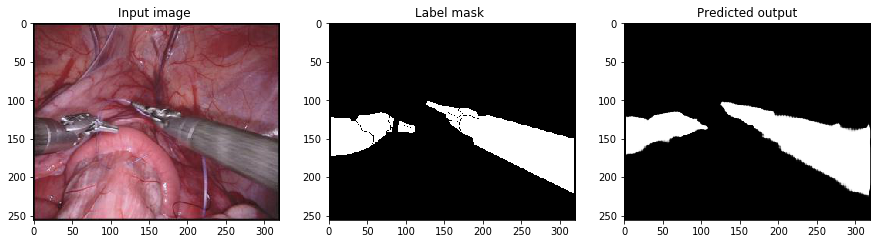

In [0]:
# Predict on the test set

model.eval()
with torch.no_grad():
    pred_dice_score=0
    test_batch = DataLoader(dataset= test_dataset, batch_size=10, shuffle = False)
    test_batch_num = len(test_batch)
    for i,(images, label) in enumerate(test_batch):
        images = Variable(images.float().cuda())
        output = model(images)
        label = Variable(one_hot_encoding(label).cuda())            
        dice_score = 1- dice_loss(output, label)
        pred_dice_score += dice_score
        
        if i==4:
          # Input image
          image1 = images[0].cpu().detach()
          image1 = image1.numpy().transpose(1,2,0)
          # Label mask
          label1 = label[0][3].cpu().detach()
          label1 = label1.view(256,320).numpy()
          # Predicted output
          output1 = output[0][3].cpu().detach()
          output1 = output1.view(256,320).numpy()
  
          fig, axs = plt.subplots(1, 3,figsize=(15,5))
          axs[0].imshow(image1)
          axs[0].set_title("Input image ")
          axs[1].imshow(label1,cmap='gray')
          axs[1].set_title("Label mask ")
          axs[2].imshow(output1,cmap='gray')
          axs[2].set_title("Predicted output")

    pred_dice_score = pred_dice_score/test_batch_num
    print('Dice score of the test set is',pred_dice_score.cpu().numpy())